In this notebook, a simple MLP will try to match a wavefield snapshot generated with Salvus for a simple homogeneous case with the parameters taken from the Moseley paper.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py

In [68]:
# Pytorch Model Name
model_dir = '../Moseley/'
model_name = 'Moseley.pt'

PATH = model_dir + model_name

# Load Salvus data
data_path = "../../NoCrack/Simple_Homogeneous_Moseley/Event0000/output.h5"
hf = h5py.File(data_path, 'r')

In [30]:
wavefield_selected = 50

df_train = pd.DataFrame()
df_train['X'] = hf['coordinates_ACOUSTIC'][:,0][:,0].astype(float)
df_train['Y'] = hf['coordinates_ACOUSTIC'][:,0][:,1].astype(float)
df_train['True'] = hf['volume']['phi'][wavefield_selected][:,0].mean(axis=1)

In [31]:
# Scaling, optional
from sklearn.preprocessing import MinMaxScaler

scaling = False

if scaling:
    scaler = MinMaxScaler()
    df_train[['X','Y','True']] = scaler.fit_transform(df_train[['X','Y','True']])


Mesh size : (300, 300)


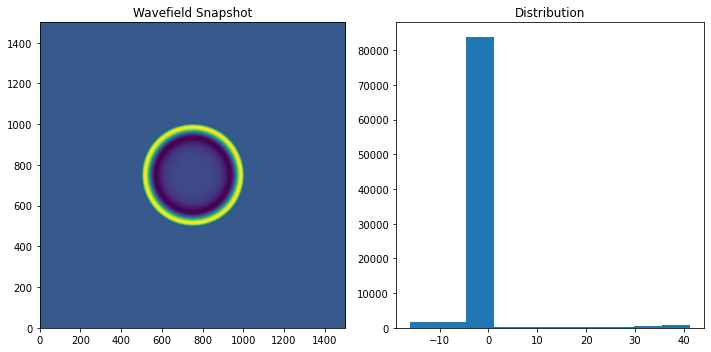

In [44]:
# Pivot Table to reorder the data
df_show = df_start.pivot_table(values='True',index='Y',columns='X').sort_index(axis=0,ascending=False)

# Plot
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(df_show.values,extent=[0,1500,0,1500])
ax[0].set_title('Wavefield Snapshot')
ax[1].hist(df_start['True'])
ax[1].set_title('Distribution')

plt.tight_layout()

print('\nMesh size :',df_show.values.shape)

In [25]:
import torch
import torch.nn as nn

from model import *

In [26]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [27]:
def train(model,X_train,y_train,loss_fn,optimizer,epoch):
    model = model.to(device)

    x = torch.tensor(X_train[:, 0:1], requires_grad=True).float().to(device)
    y = torch.tensor(X_train[:, 1:2], requires_grad=True).float().to(device)

    true = torch.tensor(y_train).float().to(device)

    tot_loss = []
    for i in range(epoch):
        model.train()

        optimizer.zero_grad()

        preds = model(torch.cat([x, y], dim=1))

        loss = loss_fn(preds,true)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('Iter %d, Loss: %.5e' % (i,loss))

        tot_loss.append(loss)

    return model, preds, tot_loss

In [28]:
def plots(df_data):
    # Compute error :
    df_data['Error'] = df_data['Preds']-df_data['True']

    # Plot :
    fig, ax = plt.subplots(1,3,figsize=(16,4))

    im = ax[0].imshow(df_data.pivot_table(values='Preds',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[0].set_title('Prediction')
    fig.colorbar(im, ax=ax[0])

    im = ax[1].imshow(df_data.pivot_table(values='True',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[1].set_title('True')
    fig.colorbar(im, ax=ax[1])

    im = ax[2].imshow(df_data.pivot_table(values='Error',index='Y',columns='X').sort_index(axis=0,ascending=False))
    ax[2].set_title('Error')
    fig.colorbar(im, ax=ax[2])

    plt.show()

In [54]:
# Collocation points with known value of the pressure - training points for the data driven approach

# Source location
xc_src = 750
yc_src = 750

# Number of colocation points
N_f = 10000

# Near the source
df_near = df_train.loc[(np.abs(df_train['X'] - xc_src) <= 300)&(np.abs(df_train['Y'] - yc_src)<=300),:].reset_index(drop=True)

idx = np.random.choice(df_near.shape[0], N_f)

df_near = df_near.loc[idx].reset_index(drop=True)

# Far from the source
df_far = df_train.loc[(np.abs(df_train['X'] - xc_src) > 300)|(np.abs(df_train['Y'] - yc_src) > 300),:].reset_index(drop=True)

idx = np.random.choice(df_far.shape[0], N_f)

df_far = df_far.loc[idx].reset_index(drop=True)

df_coloc = pd.concat((df_near,df_far),axis=0)

(0.0, 1500.0)

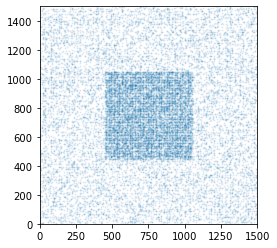

In [55]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(df_coloc.values[:,0:1], df_coloc.values[:,1:2], marker='o', alpha=0.1, s=1)
ax.set_xlim(0,1500)
ax.set_ylim(0,1500)

In [103]:
model = Model(in_size=2)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)

X_train = df_coloc.loc[:,['X','Y']].values
y_train = df_coloc.loc[:,['True']].values

In [104]:
epoch = 50000
model_trained, preds_start, loss_start = train(model,X_train,y_train,loss_fn,optimizer,epoch)

Iter 0, Loss: 9.53557e+01
Iter 100, Loss: 8.53701e+01
Iter 200, Loss: 8.46049e+01
Iter 300, Loss: 8.45247e+01
Iter 400, Loss: 8.44828e+01
Iter 500, Loss: 8.44339e+01
Iter 600, Loss: 8.43448e+01
Iter 700, Loss: 8.42207e+01
Iter 800, Loss: 8.41011e+01
Iter 900, Loss: 8.39863e+01
Iter 1000, Loss: 8.38641e+01
Iter 1100, Loss: 8.44481e+01
Iter 1200, Loss: 8.37312e+01
Iter 1300, Loss: 8.35975e+01
Iter 1400, Loss: 8.34305e+01
Iter 1500, Loss: 8.32618e+01
Iter 1600, Loss: 8.28979e+01
Iter 1700, Loss: 8.37968e+01
Iter 1800, Loss: 8.20902e+01
Iter 1900, Loss: 8.15409e+01
Iter 2000, Loss: 8.11264e+01
Iter 2100, Loss: 8.07124e+01
Iter 2200, Loss: 8.24178e+01
Iter 2300, Loss: 7.98766e+01
Iter 2400, Loss: 8.01658e+01
Iter 2500, Loss: 8.02655e+01
Iter 2600, Loss: 7.46222e+01
Iter 2700, Loss: 7.26675e+01
Iter 2800, Loss: 7.09646e+01
Iter 2900, Loss: 6.82239e+01
Iter 3000, Loss: 6.67469e+01
Iter 3100, Loss: 6.54255e+01
Iter 3200, Loss: 6.43064e+01
Iter 3300, Loss: 6.36705e+01
Iter 3400, Loss: 6.42370e+

In [105]:
# Save model parameters

print('path: ',PATH)
torch.save(model_trained.state_dict(), PATH)

path:  ../Moseley/Moseley.pt


### Predicitons 

In [106]:
# Load model 
print('path: ',PATH)

model_test = Model(in_size=2)
model_test.load_state_dict(torch.load(PATH))

# Predictions
model_test.eval()

X_train = df_train.loc[:,['X','Y']].values

x_test = torch.tensor(X_train[:,:1]).float()
y_test = torch.tensor(X_train[:,1:2]).float()

preds = model_test(torch.cat([x_test, y_test], dim=1))
preds = preds.detach().cpu().numpy() # From tensor to np.array

path:  ../Moseley/Moseley.pt


In [107]:
df_train['Preds'] = preds

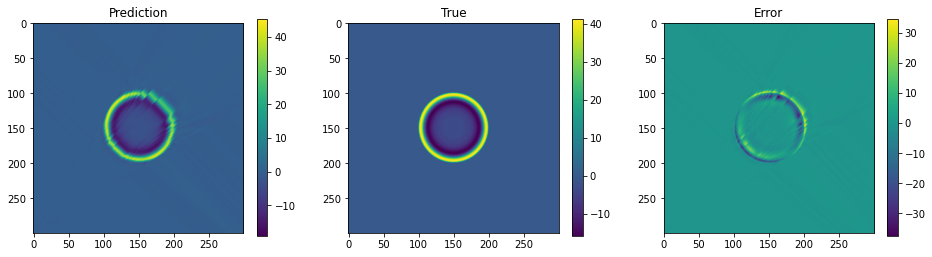

In [108]:
plots(df_train)